**Econ691-06 | Hanh Nong**
# <center>ASSIGNMENT 4</center>

In [1]:
#setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sfa
from statsmodels.iolib.summary2 import summary_col
from scipy import stats
import seaborn as sns
from scipy.stats import norm
from sklearn.linear_model import Ridge, Lasso
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## PROBLEM: Shrinkage

The data scientists at Youtube have been running a series of week-long experiments to improve time spent on the platform. Specifically, the Youtube team has run fifty experiments over the last few months, each of which includes 2,000 users, split between 1,000 treated and 1,000 control users. For each experiment and for each user in that experiment, Youtube records the change in time spent on the website (in minutes) for that week, relative to the user’s previous week. The data scientists have of course analyzed each experiment in isolation and using standard frequentist approaches; but they have asked you to explore if shrinkage analysis can potentially improve on the estimates of the treatment effect.

The raw data from these fifty experiments is in the file data_assignment5 _1.csv. The file has 100,000 rows. Each row corresponds to a separate user in a separate experiment, for which there are three columns. The first column is the change in time spent on the website. The second column is an indicator for whether they are in the treated or control group. The third column indicates which experiment (1 - 50) that the user is in.

While the true treatment effects are generally unknown in practice, I have provided them in the file data_assignment5_2.csv to illustrate the improvements in the various techniques. This file has 50 rows. Each row corresponds to a separate experiment, for which there are two columns: the true treatment effect in the first column, and the experiment number in the second column. Note that this file should only be used for assessing the mean-squared error of your estimated treatment effects, and not for generating those estimates in the first place.

In [2]:
data1 = pd.read_csv("data_assignment5_1.csv")
data2 = pd.read_csv("data_assignment5_2.csv")

In [9]:
data1.info()
data1.nunique()
data1.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
outcome              100000 non-null float64
treatment            100000 non-null int64
experiment_number    100000 non-null int64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


outcome              100000
treatment                 2
experiment_number        50
dtype: int64

,outcome,treatment,experiment_number
count,100000.000000,100000.000000,100000.000000
mean,0.036182,0.500000,25.500000
std,20.010126,0.500003,14.430942
min,-82.231777,0.000000,1.000000
25%,-13.446321,0.000000,13.000000
50%,0.065919,0.500000,25.500000
75%,13.535747,1.000000,38.000000
max,81.278179,1.000000,50.000000


In [14]:
data2.info()
data2.nunique()
data2.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
true_effect          50 non-null float64
experiment_number    50 non-null int64
dtypes: float64(1), int64(1)
memory usage: 880.0 bytes


true_effect          50
experiment_number    50
dtype: int64

,true_effect,experiment_number
count,50.000000,50.00000
mean,0.094321,25.50000
std,1.243504,14.57738
min,-2.484654,1.00000
25%,-0.846226,13.25000
50%,0.002311,25.50000
75%,0.832266,37.75000
max,4.187713,50.00000


In [81]:
#Set up list to store differences of all 6 approaches
diff_list = []

### 1. (10 points)
Using the experimental data only, estimate the effect of each of the fifty experiments per standard (i.e. frequentist) regression analysis. Report the mean-squared error of your estimates across the fifty experiments, by comparing them to the true treatment effects.

In [58]:
effect_obs = []
mse_freq = 0
for i in data1['experiment_number'].unique():
    reg_freq = sfa.ols("outcome ~ treatment" , 
                       data1.query("experiment_number == @i")).fit()
    effect_obs.append(reg_freq.params[1])
    mse_freq += (reg_freq.params[1] - 
                 data2.query("experiment_number == @i")['true_effect'].values[0])**2
effect_obs = np.array(effect_obs)
mse_simple = mse_freq/data1['experiment_number'].nunique()
print("MSE, frequentist method:", round(mse_simple,3))

MSE, frequentist method: 1.061


In [82]:
#Store diff to list
diff_list.append(effect_obs - data2['true_effect'])

### 2. (15 points)
Using the James-Stein estimator, adjust your estimates from Question 1. Report the shrinkage factor that you are using. Then report the mean-squared error of your estimates, by comparing them to the true treatment effects

• As a hint, remember that you will have to compute the variance of the observed treatment effects, as drawn from the true treatment effect. To compute this, think about why the observed treatment effect can differ from the true treatment effect; and compute the variance accordingly.

In [5]:
#Compute std of estimates in each experiment, by using bootstrap
#then take average of these std across experiments
mean_bstr = []
std_bstr = []
for i in range(1,51):
    subset = data1.query('experiment_number == @i')
    bstr = []
    for j in range(100):
        idx_t = np.random.choice(np.where(subset['treatment'] == 1)[0], 
                                 replace = True, 
                                 size = np.sum(subset['treatment']))
        idx_c = np.random.choice(np.where(subset['treatment'] == 0)[0], 
                                 replace = True, 
                                 size = np.sum(subset['treatment']))
        sample = pd.concat([subset.iloc[idx_t],subset.iloc[idx_c]], 
                           ignore_index=True, sort=False)
        reg = sfa.ols("outcome ~ treatment", sample).fit()
        bstr.append(reg.params[1])
    mean_bstr.append(np.mean(bstr))
    std_bstr.append(np.std(bstr))

In [88]:
#std across experiments
np.mean(std_bstr)

0.88624978290644

In [7]:
factor = (1 - (len(effect_obs) - 2) * (np.mean(std_bstr)**2)/sum(effect_obs**2))

mse_js = np.mean((effect_obs*factor - data2['true_effect'])**2)
print("James-Stein factor:", round(factor,3))
print("MSE, James-Stein method:", round(mse_js,3))

James-Stein factor: 0.735
MSE, James-Stein method: 0.629


In [83]:
#Store diff to list
diff_list.append(effect_obs*factor - data2['true_effect'])

**Second attempt**

$\bar{y_t}:$ Mean of outcome from treatment units <br>
$\bar{y_c}:$ Mean of outcome from control units

We have: $\hat{\beta} = \bar{y_t} - \bar{y_c} \longrightarrow Var(\hat\beta) = Var(\bar{y_t}) + Var(\bar{y_c}) - 2[E(\bar{y_t}.\bar{y_c}) - E(\bar{y_1}).E(\bar{y_0})]$

Results from codes below: <br>
$Var(\bar{y_t}) = 2.13$<br>
$Var(\bar{y_t}) = 0.47$<br>
$Cov(\bar{y_t},\bar{y_c}) = -0.1$

Results show the variances in treatment outcome vary much more than in control outcome and largely contribute to the variances of estimates. If our estimates are closed to the true effects, meaning free from bias, we expect the variances of treatment outcome should be closed to that of control units (~0.47), based on assumption that treatment only shifts outcomes upward or downward but should not widen the difference between observations; and hence the larger gap indicates the presence of extranous variables. This gap between these two variances possibly is due to bias, and it's also what keep our estimates far away from true estimates. Hence, my naive approach is to take the difference between these two as variance for JS method.

Comparing with the 1st approach: JS factor is much smaller but MSE is not much improved. Hence, I still go with 1st approach.

In [91]:
data1_group = data1.groupby(['experiment_number', 'treatment'])['outcome'].mean().unstack(-1)
data1_group.columns = ['control', 'treatment']
var_yt = np.std(data1_group['treatment'])**2
var_yc = np.std(data1_group['control'])**2
mean_ytyc = np.mean(data1_group['treatment']*data1_group['control'])
mean_yt = np.mean(data1_group['treatment'])
mean_yc = np.mean(data1_group['control'])
var_effect = var_yt - var_yc
print("var in mean of treatment outcome:",round(var_yt,3))
print("var in mean of control outcome:",round(var_yc,3))
print("cov(treatment, control mean):",round(mean_ytyc- mean_yt*mean_yc,3))
print("diff in variances between treatment & control:", round(var_effect,3))

var in mean of treatment outcome: 2.138
var in mean of control outcome: 0.473
cov(treatment, control mean): -0.101
diff in variances between treatment & control: 1.665


In [94]:
factor2 = (1 - (len(effect_obs) - 2) * var_effect/sum(effect_obs**2))

mse_js2 = np.mean((effect_obs*factor2 - data2['true_effect'])**2)
print("James-Stein factor, 2nd approach:", round(factor2,3))
print("MSE, James-Stein method, 2nd approach:", round(mse_js2,3))

James-Stein factor, 2nd approach: 0.439
MSE, James-Stein method, 2nd approach: 0.619


### 3. (15 points)
Using the split-sample empirical Bayesian estimator, adjust your estimates from Question 1. Report the parameters of the shrinkage model you are using. Then report the mean-squared error of your estimates, by comparing them to the true treatment effects.

In [9]:
effect_split_1 = []
effect_split_2 = []
for i in range(1,51):
    #Step 1: Split each experiment in half
    subset = data1.query('experiment_number == @i').reset_index()
    nt1 = (np.sum(subset['treatment'])/2).astype(int)
    nc1 = ((len(subset) - nt1)/2).astype(int)
    idx = np.concatenate([np.random.choice(np.where(subset['treatment'] == 1)[0],
                                           replace = False,
                                           size = nt1),
                         np.random.choice(np.where(subset['treatment'] == 0)[0],
                                          replace = False,
                                          size = nc1)])
    #Step 2: Estimate treatment effect within each half
    effect_split_1.append(sfa.ols("outcome ~ treatment", subset.iloc[idx]).fit().params[1])
    effect_split_2.append(sfa.ols("outcome ~ treatment", subset.drop(idx)).fit().params[1])    

#Step 3: Regress first effect on the second one to get shrink factor
effect_split = pd.DataFrame({'effect1':effect_split_1,'effect2':effect_split_2})
factor_split = sfa.ols("effect1 ~ effect2", effect_split).fit().params[1]

#Step4: Estimate treatment effect with shrink factor & compute MSE
mse_split = np.mean((effect_obs*factor_split - data2['true_effect'])**2)

print("Shrink factor, split sample method:", round(factor_split,3))
print("MSE, split sample method:", round(mse_split,3))

Shrink factor, split sample method: 0.56
MSE, split sample method: 0.563


In [84]:
#Store diff to list
diff_list.append(effect_obs*factor_split - data2['true_effect'])

### 4. (20 points) *(Answer for Q.4 is in Q.5)*

Using LASSO, create new estimates of treatment effects for each experiment. In order to tune the parameter α, demonstrate two different cross-validation approaches, both using the mean-squared error in the predicted versus actual response values as the
metric. First, set the optimal α within each experiment, defined as the alpha corresponding to the lowest mean-squared error for that experiment. Second, find the optimal α across all experiments, defined as the alpha corresponding to the lowest average mean-squared error across all experiments. For this second approach, report the optimal α you find. Under both approaches, you should use five cross-validation folds. Once you have generated your set of estimates for each of the two tuning approaches, report the mean-squared error for that set of estimates, by comparing them to the true treatment effects. Thus, you should have two mean-squared errors for this question.

• You should search α ∈ [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]. You also should not use any inbuilt functions to search for the optimal α, such as GridSearchCV (Python); but should code from scratch, as we did in class.

• As a hint, remember that you fit each experiment and compute each metric (e.g. meansquared error between ˆy and y) individually under both approaches. The difference between computing a per-experiment or pooled α only comes once you have all metrics. At that point, you can either find the minimum metric and corresponding α for each experiment; or you can find the average minimum metric and corresponding α across all experiments.

• Given the number of folds and the variation in inputs, you are strongly encouraged to write a modular function to keep your code efficient and readable

### 5. (10 points) 
Using Ridge Regression, create new estimates of treatment effects for each experiment, utilizing a third cross-validation approach. Continue to use five cross-validation folds, and continue to find the optimal α across all experiments (rather than within each experiment) as in the second approach previously. However, now use the mean-squared difference between the estimated and OLS coefficient as the metric. Report the optimal α you find. Moreover, report the mean-squared error of your estimates, by comparing them to the true treatment effects.

In [144]:
#Set up function for cross-validation
def cv_shrinkage(data, d_col, y_col, K, alpha):
    #d_col: treatment column, y_col: outcome column, K: number of folds
    #Step 0: prepare placeholders
    lasso = Lasso(alpha = alpha, normalize = True, fit_intercept = True)
    ridge = Ridge(alpha = alpha, normalize = True, fit_intercept = True)
    mse_lasso = []
    mse_ridge = []
    
    #STEP 1: split data into K folds    
    idx_kt = np.split(ary = np.random.choice(np.where(data[d_col] == 1)[0],
                                             replace = False,
                                             size = (np.sum(data[d_col])).astype(int)), 
                      indices_or_sections = K)
    idx_kc = np.split(ary = np.random.choice(np.where(data[d_col] == 0)[0],
                                             replace = False,
                                             size = (len(data) - data[d_col].sum()).astype(int)),
                      indices_or_sections = K)
    
    idx = np.concatenate((idx_kt, idx_kc), axis = 1)

    for k in range(K):
        #STEP 2: train model on remaining folds
        #lasso.fit(data.iloc[idx[~k]][[d_col]], data.iloc[idx[~k]][y_col])
        #ridge.fit(data.iloc[idx[~k]][[d_col]], data.iloc[idx[~k]][y_col])
        idx_notk = np.delete(idx,k,0).flatten()
        lasso.fit(data.iloc[idx_notk][[d_col]], data.iloc[idx_notk][y_col])
        ridge.fit(data.iloc[idx_notk][[d_col]], data.iloc[idx_notk][y_col])
                
        #STEP 3: test model on the kth fold
        y_pred_lasso = lasso.predict(data.iloc[idx[k]][[d_col]])
        effect_ridge = ridge.coef_[0]

        #STEP 4: compute MSE for each fold
        mse_lasso.append(np.mean((y_pred_lasso - data.iloc[idx[k]][y_col])**2))
        mse_ridge.append((effect_ridge - 
                          sfa.ols(y_col+'~'+d_col, data.iloc[idx[k]]).fit().params[1])
                         **2)
    #STEP 5: get the mean of mse across folds
    return np.mean(mse_lasso), np.mean(mse_ridge)

In [145]:
import warnings
warnings.filterwarnings('ignore')

#STEP 6: Find optimal alpha

Alpha = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]
mse_lasso = []
mse_ridge = []
for i in range(1,51):
    subset = data1.query('experiment_number == @i')
    mse_alpha_lasso, mse_alpha_ridge = [], []
    for alpha in Alpha:
        shrinkage_results = cv_shrinkage(data = subset, 
                                         d_col = 'treatment', y_col = 'outcome', 
                                         K = 5, alpha = alpha)
        mse_alpha_lasso.append(shrinkage_results[0]) #mse of 1 experiment across all alphas
        mse_alpha_ridge.append(shrinkage_results[1]) #mse of 1 experiment across all alphas
    mse_lasso.append(mse_alpha_lasso) #mse across experiments & alphas
    mse_ridge.append(mse_alpha_ridge) #mse across experiments & alphas
    
mse_lasso_df = pd.DataFrame(data = np.array(mse_lasso)[0:,0:], columns = [str(i) for i in Alpha])
mse_ridge_df = pd.DataFrame(data = np.array(mse_ridge)[0:,0:], columns = [str(i) for i in Alpha])
mse_lasso_df.head(2)
mse_ridge_df.head(2)

#Approach 1 (for Question 4):
#get min of mse for each experiment, then pick alpha of the min mse
alpha_aprch_1 = mse_lasso_df.idxmin(axis = 1).astype(np.float) 

#Approach 2 (for Question 4):
#get min of mean-mse across experiment, then pick alpha of the experiment with lowest mse
alpha_aprch_2 = float(np.argmin(mse_lasso_df.mean(axis = 0)))

#Approach 3 (for Question 5):
#get min of mean-mse across experiment, then pick alpha of the experiment with lowest mse
alpha_aprch_3 = float(np.argmin(mse_ridge_df.mean(axis = 0)))

,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100
0,401.648110,402.082720,402.314292,402.723605,402.424100,402.771345,402.370636,402.681288,402.363807,402.70597,403.066729
1,392.762282,392.017077,392.130505,394.162724,393.425257,393.249692,393.012451,393.575488,393.239764,393.28680,392.971746


,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100
0,3.053786,7.461242,3.356058,2.676743,3.908905,6.556453,6.244078,4.306717,6.379441,7.284220,4.622310
1,11.785345,4.292920,0.887283,4.111230,17.257591,7.069741,4.405849,5.256753,6.325773,6.068573,5.572826


In [146]:
#STEP 7: Train model on the whole data, using optimal alpha

effect_aprch_1 = [] # (for Question 4)
effect_aprch_2 = [] # (for Question 4)
effect_aprch_3 = [] # (for Question 5)
for i in range(1,51):
    subset = data1.query('experiment_number == @i')
    
    #Approach 1:
    lasso = Lasso(alpha = alpha_aprch_1[i-1], normalize = True, fit_intercept = True)
    lasso = lasso.fit(subset[['treatment']], subset['outcome'])
    effect_aprch_1.append(lasso.coef_[0])
    
    #Approach 2:
    lasso = Lasso(alpha = alpha_aprch_2, normalize = True, fit_intercept = True)
    lasso = lasso.fit(subset[['treatment']], subset['outcome'])
    effect_aprch_2.append(lasso.coef_[0])
    
    #Approach 3:
    ridge = Ridge(alpha = alpha_aprch_3, normalize = True, fit_intercept = True)
    ridge = ridge.fit(subset[['treatment']], subset['outcome'])
    effect_aprch_3.append(ridge.coef_[0])

#STEP 8: Get MSE
mse_aprch_1 = np.mean((effect_aprch_1 - data2['true_effect'])**2)
mse_aprch_2 = np.mean((effect_aprch_2 - data2['true_effect'])**2)
mse_aprch_3 = np.mean((effect_aprch_3 - data2['true_effect'])**2)
print("ANSWER TO QUESTION 4:\n-------------------------------------------")
print("MSE, Lasso with 5 folds, approach 1:", round(mse_aprch_1,3))
print("Optimal alpha for Lasso, approach 2:", round(alpha_aprch_2,3))
print("MSE, Lasso with 5 folds, approach 2:", round(mse_aprch_2,3))
print("\nANSWER TO QUESTION 5:\n-------------------------------------------")
print("Optimal alpha for Ridge, approach 3:", round(alpha_aprch_3,3))
print("MSE, Ridge with 5 folds, approach 3:", round(mse_aprch_3,3))

ANSWER TO QUESTION 4:
-------------------------------------------
MSE, Lasso with 5 folds, approach 1: 0.891
Optimal alpha for Lasso, approach 2: 0.01
MSE, Lasso with 5 folds, approach 2: 0.65

ANSWER TO QUESTION 5:
-------------------------------------------
Optimal alpha for Ridge, approach 3: 1.0
MSE, Ridge with 5 folds, approach 3: 0.58


In [147]:
#Store diff to list
diff_list.extend([effect_aprch_1 - data2['true_effect'], 
                  effect_aprch_2 - data2['true_effect'], 
                  effect_aprch_3 - data2['true_effect']])

### 6. (10 points)

You now have six sets of estimates from six distinct approaches: the simple frequentist estimates, the James-Stein estimates, the split-sample estimates, the LASSO estimates with the per-experiment α, the LASSO experiments with the single α, and the Ridge Regression estimates. On a single histogram or density plot, graph the the differences between the estimated treatment effect and the true treatment effect, across all fifty experiments and using different colors for each approach. As always, points will be awarded on the basis of the ease of understanding your visualization.

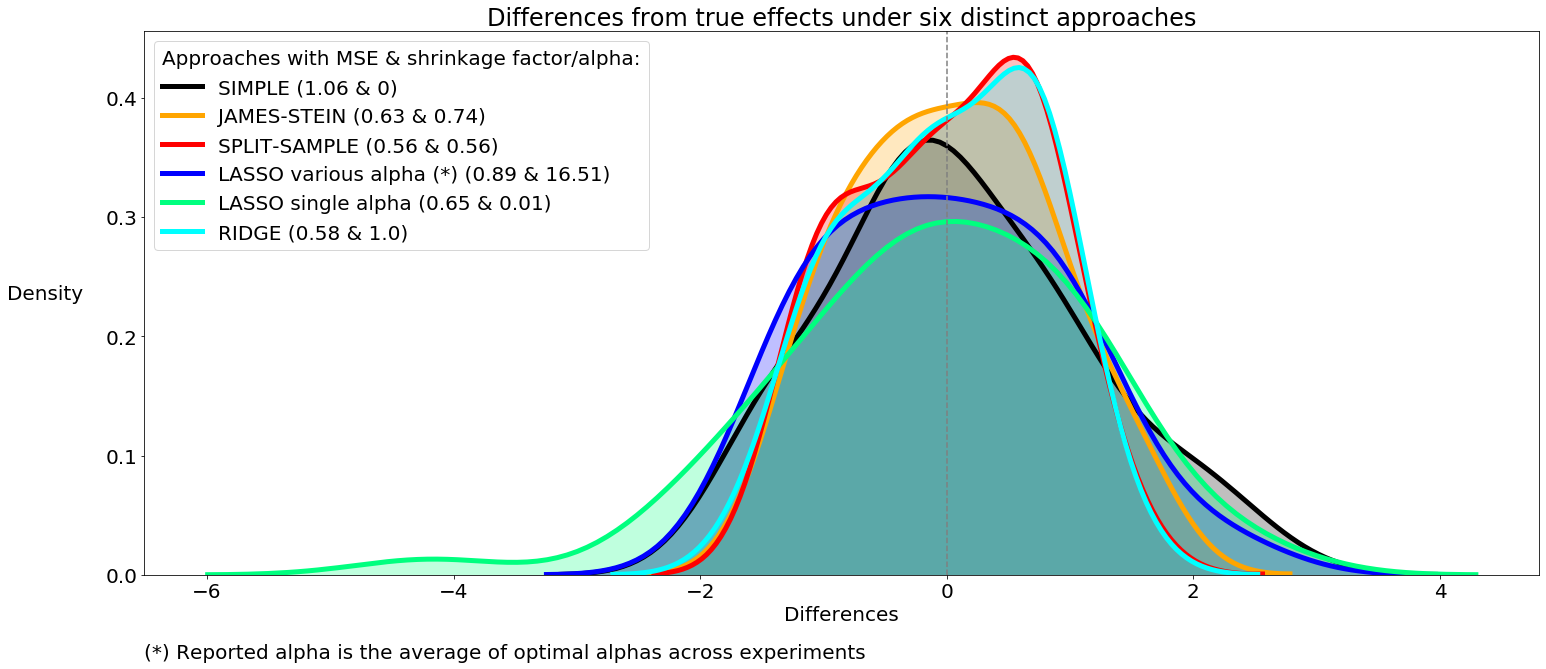

In [148]:
mse = [mse_simple, mse_js, mse_split, mse_aprch_1, mse_aprch_2, mse_aprch_3]
shrinkage = [0,factor,factor_split, np.mean(alpha_aprch_1), alpha_aprch_2, alpha_aprch_3]
color = ['black', 'orange', 'red', 'blue', 'springgreen', 'aqua']
aprch = ['SIMPLE','JAMES-STEIN','SPLIT-SAMPLE', 
         'LASSO various alpha (*)', 'LASSO single alpha', 'RIDGE']

plt.rcParams.update({'font.size': 20})
plt.figure(figsize = (25,10))
for i in range(6):
    label_i = aprch[i]+' ('+str(round(mse[i],2))+' & '+str(round(shrinkage[i],2))+')'
    sns.kdeplot(diff_list[i], label = label_i, color = color[i], shade = True, linewidth = 5)
    #sns.kdeplot(diff[i], label = i)

plt.axvline(x = 0, color = 'grey', ls = '--')
plt.title('Differences from true effects under six distinct approaches')
plt.xlabel('Differences')
plt.ylabel('Density', rotation = 0, labelpad = 60)
plt.legend(title = 'Approaches with MSE & shrinkage factor/alpha:')._legend_box.align='left'
plt.figtext(0.125, 0.01, 
            '(*) Reported alpha is the average of optimal alphas across experiments', 
            ha='left');

### 7. (10 points)

Discuss the advantages and disadvantages of each of the six approaches. Which would you recommend the Youtube data scientists use going forward? Limit your entire answer to approximately three hundred words.

1.	Simple frequentist approach:
    -	Advantages:    
        •	Less computational than shrinkage model since a shrinkage factor is not needed in this approach. <br>
        •	Less biased than shrinkage model.        
    -	Disadvantages: <br>
        •	Higher variance than all other models (except Lasso 2).


2.	James-Stein approach:
    -	Advantages:     
        •	Works almost all the time        
        •	Shrinking process is less heavier and ad-hoc than Lasso, Ridge       
    -	Disadvantages:    
        •	Not always straightforward to obtain “variance” in the James-Stein factor formula. The magnitude of improvement depends on how accurate the “variance” is. <br>
        •   It could be complicated if our variance is not constant across observations.


3.	Split-sample approach:

    -	Advantages:<br>
        •	Very simple process, easy to understand and explain        
        •	We don’t have to deal with estimating “variance” as in JS, but this approach still works and in this particular problem, it works better than JS.
    -	Disadvantages:    
        •	Since split-sample works for two folds, it could be a challenge if our data is limited or there are too much variations in data.


4.	Lasso 1 – Lasso with various alphas approach:
    -	Advantages:    
        •	More complicated than JS in shrinking estimates but it is easier to explain the shrinking process, and hence, somehow is more convincing and believable than JS.        
        •	Shrinkage varies among experiments makes the estimates less biased than JS and Split-sample but also produces higher variance.        
        
    -	Disadvantages:    
        •	Finding optimal alpha is time consuming and ad hoc.


5.	Lasso 2 – Lasso with single alpha approach:
    -	Advantages:    
        •	Simpler than Lasso 1 as we apply one single alpha for all experiments. Our results are the least biased among approaches.        
    -	Disadvantages:    
        •	The variance is way too high that it makes Lasso 2 the worst approach among all. If the number of experiments is not too large or the variations between experiments is not that much, this approach might perform better.        


6.	Ridge approach:
    -	Advantages:    
        •	Ridge results’ distribution is almost identical to that of Split-sample.         
        •	It works much more efficient than both Lasso as it uses only one alpha but its MSE is lower than Lasso 1 and just half of Lasso 2.        
    -	Disadvantages:<br>
        •	For an approach that has the same results as Split-sample, it is too complicated and time-consuming
        

I would recommend to use Split-sample approach as it works like cross-validation with two folds, but it's much simpler than Lasso or Ridge and yet produces good results. There is no information about number of variables that should be included in estimating effect. I might recommend another approach (eg. Lasso 1) if our data is multi-dimensional.